# training samples:60000
# testing samples:10000
image size: (28, 28)
features per sample: 784


/home/freddy/dev/mnist-pytorch/.env/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


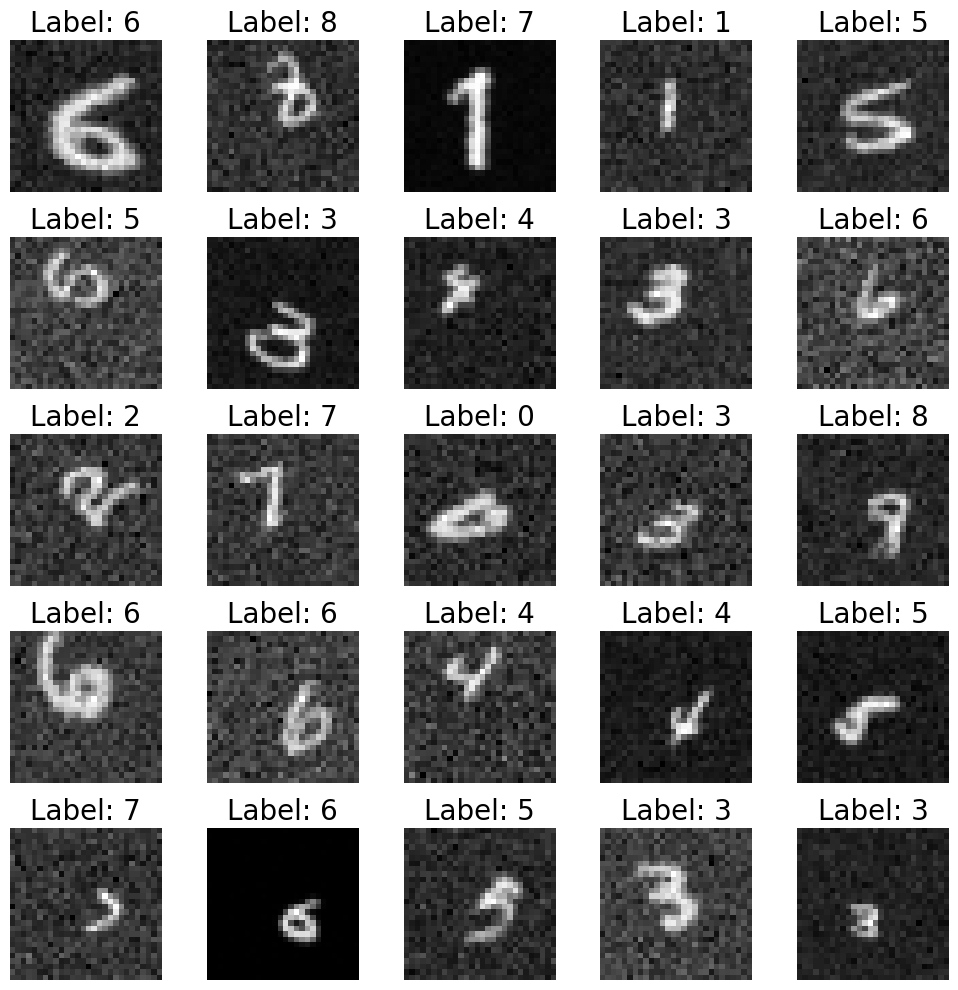

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from PIL import Image
from model import model_options
from data import get_data

trainloader, testloader = get_data(model_options['batch_size'])

def show_images(images, labels, predictions=None):
    num_cols = 5
    num_rows = math.ceil(len(images) / num_cols)
    fig = plt.figure(figsize=(10, 2 * num_rows))
    for i in range(len(images)):
        ax = fig.add_subplot(num_rows, num_cols, i+1, xticks=[], yticks=[])
        if predictions is not None:
            color = "green" if predictions[i] == labels[i] else "red"
            ax.set_title(f"Label: {labels[i]}\nPred: {predictions[i]}", fontsize=20, color=color)
        else:
            ax.set_title(f"Label: {labels[i]}", fontsize=20)
        ax.axis('off')
        
        image = images[i]
        if isinstance(image, Image.Image):
            ax.imshow(image, cmap='gray')
        else:
            ax.imshow(image.squeeze().numpy(), cmap='gray')
    plt.tight_layout()
    plt.show()

example_images, example_labels = next(iter(testloader))

show_images(example_images[:25], example_labels[:25])

In [2]:
import torch
from model import model_options, model, optimizer, scheduler, loss_function

# see model.py for the model architecture

print("Is cuda available?", torch.cuda.is_available())
print()
for key, value in model_options.items():
    print(f"{key.replace('_', ' ').title()}: {str(value)}")
print()
print("Model Architecture:")
print(model)


Is cuda available? True

Epochs: 3
Batch Size: 100
Eval Batch Interval: 100
Learning Rate: 0.002
Learning Rate Decay Ratio: 0.3
Weight Decay: 0.0001
Dropout: 0.2

Model Architecture:
Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=3136, out_features=1000, bias=True)
  (8): ReLU()
  (9): Dropout(p=0.2, inplace=False)
  (10): Linear(in_features=1000, out_features=128, bias=True)
  (11): ReLU()
  (12): Dropout(p=0.2, inplace=False)
  (13): Linear(in_features=128, out_features=10, bias=True)
)


* Using GPU with CUDA
* Epoch 3/3
* Batch 500/600
* Sample 50000/60000
* Learning Rate 6.94e-04 (34.69%)
* Training Loss: 0.42668
* Validation Loss: 0.36206
* Accuracy: 88.50% 8850/10000

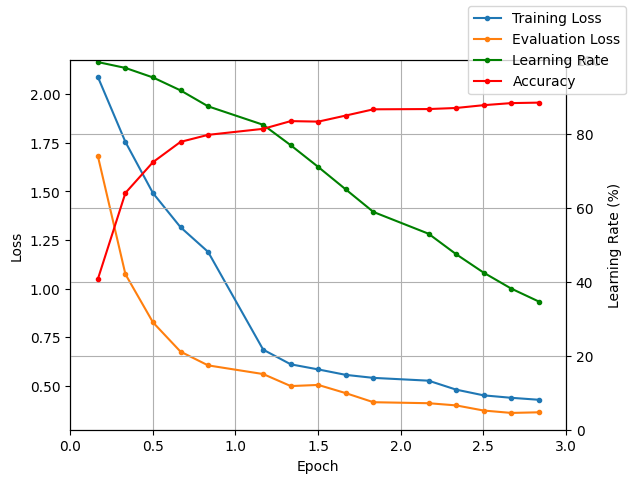

Finished training


In [3]:
from IPython import display
%matplotlib inline

device_name = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_name)

model.to(device)
loss_function.to(device)

num_batches = len(trainloader)

plt.ion()

fig, ax1 = plt.subplots()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True, axis='x')
ax2 = ax1.twinx()
ax2.set_ylabel('Learning Rate (%)')
ax2.grid(True)

ax1.set_xlim(0, model_options['epochs'])
ax2.set_ylim(0, 100)
ax2.set_xlim(0, model_options['epochs'])

training_loss = {}
eval_loss = {}
learning_rates = {}
accuracies = {}

t_line, = ax1.plot([], [], label='Training Loss', marker='.')
e_line, = ax1.plot([], [], label='Evaluation Loss', marker='.')
lr_line, = ax2.plot([], [], label='Learning Rate', color='green', marker='.')
a_line, = ax2.plot([], [], label='Accuracy', color='red', marker='.')

fig.legend()

train_progress_display = display.display(display.Markdown(""), display_id=True)
graph_display = display.display(display.Markdown("Loading..."), display_id=True)

for epoch in range(model_options['epochs']):
    training_losses = []
    model.train()
    for batch_index, (data, target) in enumerate(trainloader):
        percent_epoch = (batch_index + 1) / num_batches
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()
        training_losses.append(loss.item())
        
        if batch_index % model_options['eval_batch_interval'] == 0 and batch_index > 0:
            scheduler.step()
            model.eval()
            test_losses = []
            with torch.no_grad():
                correct = 0
                total = 0
                for inputs, labels in testloader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    outputs = model(inputs)
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    test_losses.append(loss_function(outputs, labels).item())
                    
                    training_loss[epoch + percent_epoch] = np.mean(training_losses)
                    eval_loss[epoch + percent_epoch] = np.mean(test_losses)
                    learning_rates[epoch + percent_epoch] = scheduler.get_last_lr()[0]
                    accuracies[epoch + percent_epoch] = correct / total * 100
            
            train_progress_display.update(display.Markdown("\n".join([
                "* Using GPU with CUDA" if device_name == "cuda" else "Using CPU",
                f"* Epoch {epoch + 1}/{model_options['epochs']}",
                f"* Batch {batch_index}/{num_batches}",
                f"* Sample {batch_index * model_options['batch_size']}/{num_batches * model_options['batch_size']}",
                f"* Learning Rate {scheduler.get_last_lr()[0]:.2e} ({format(scheduler.get_last_lr()[0] / model_options['learning_rate'] * 100, '.2f')}%)",
                f"* Training Loss: {format(np.mean(training_losses), '.5f')}",
                f"* Validation Loss: {format(np.mean(test_losses), '.5f')}",
                f"* Accuracy: {format(100 * correct / total, '.2f')}% {correct}/{total}",
            ])))
            
            t_line.set_xdata(list(training_loss.keys()))
            t_line.set_ydata(list(training_loss.values()))
            e_line.set_xdata(list(eval_loss.keys()))
            e_line.set_ydata(list(eval_loss.values()))
            lr_line.set_xdata(list(learning_rates.keys()))
            lr_line.set_ydata(list([round(r / model_options['learning_rate'] * 100, 2) for r in learning_rates.values()]))
            a_line.set_xdata(list(accuracies.keys()))
            a_line.set_ydata(list(accuracies.values()))

            ax1.relim()
            ax1.autoscale_view()

            graph_display.update(plt.gcf())

plt.close(fig)

print("Finished training")

Using GPU with CUDA


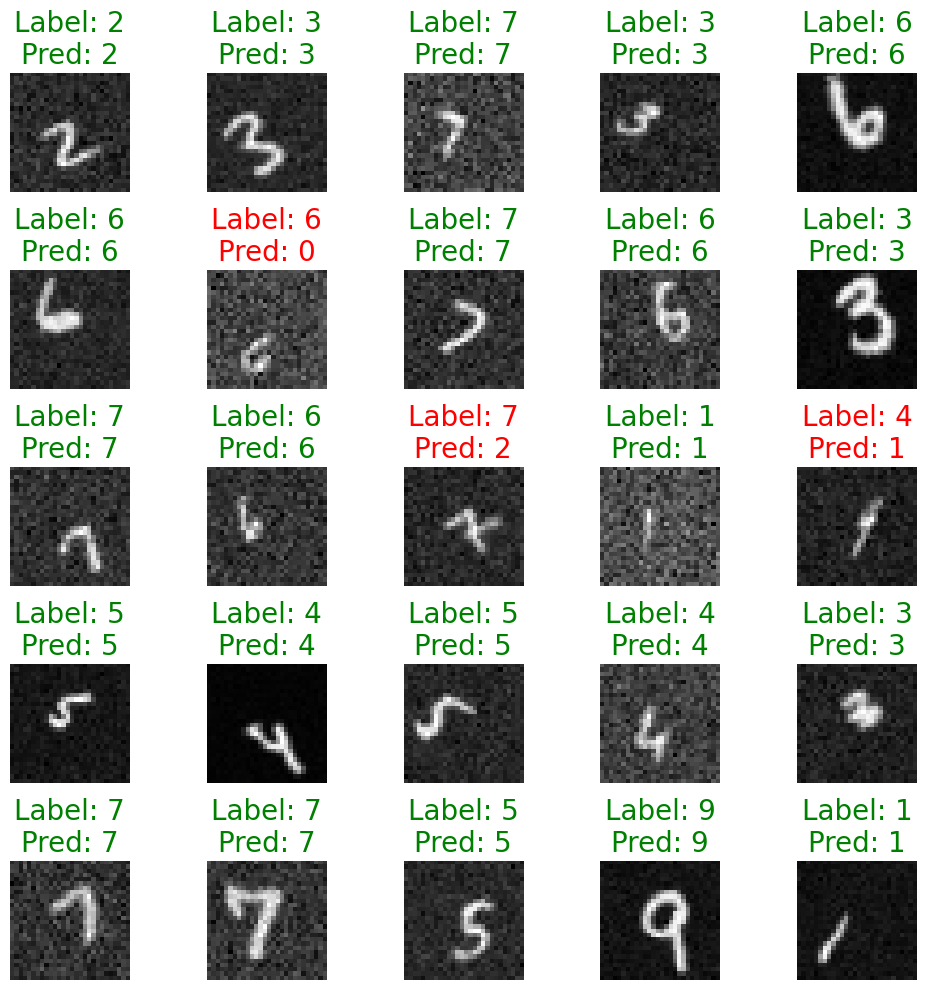

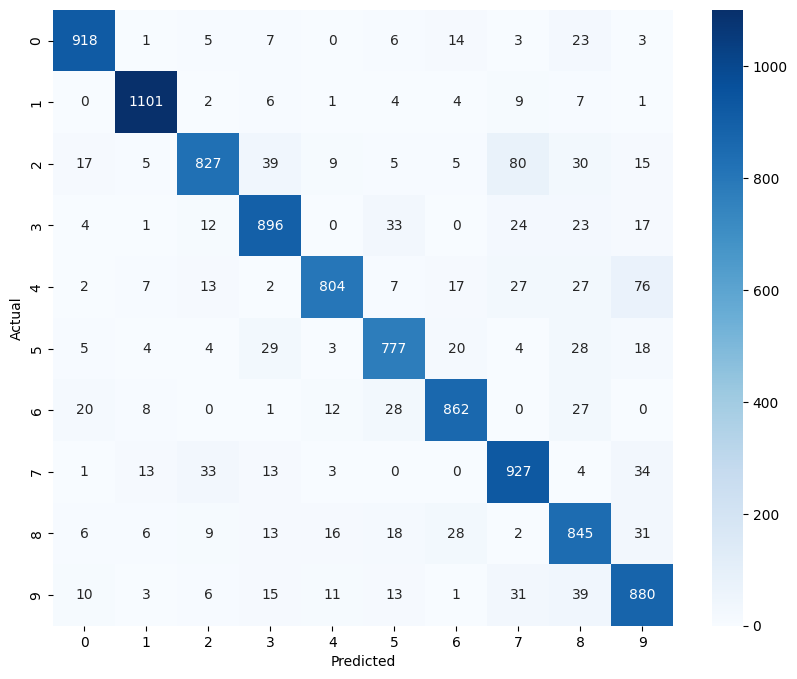

In [4]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

device_name = "cuda" if torch.cuda.is_available() else "cpu"
print("Using GPU with CUDA" if device_name == "cuda" else "Using CPU")
device = torch.device(device_name)

# show some predictions
model.eval()

images, labels = next(iter(testloader))
images = images[:25]
labels = labels[:25]
images = images.to(device)
labels = labels.to(device)
outputs = model(images)
_, predictions = torch.max(outputs, 1)
show_images(images.cpu(), labels.cpu(), predictions.cpu())

# predict on test dataset
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

y_pred_classes = [np.argmax(output) for output in y_pred]

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [5]:
# save the model
torch.save(model.state_dict(), "model.pth")